
#**ΕΡΩΤΗΜΑΤΑ**

In [1]:
from google.colab import drive
drive.mount("/content/drive")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

%matplotlib inline 

Mounted at /content/drive


In [ ]:
moviesdf = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IMDb movies.csv")
ratingsdf = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IMDb ratings.csv")
netflixdf = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/netflix_titles.csv")

### Αν υπάρχει κάποιο κενό data entry στο πεδίο date_added το διαγράφουμε, επειδή έχουμε να κάνουμε με strings και δεν θέλουμε να αλλοιώσουμε τα δεδομένα μας.
### ΣΗΜΕΊΩΣΗ: Υπάρχουν κενά στα πεδία cast, director. Όμως, επειδή χρησιμοποιούνται μόνο στα ερωτήματα 5,9 κάνω αντιγραφή το dataframe σε εκείνα τα ερωτήματα και έπειτα διαγράφω τα όλες τις σειρές που έχουνε κενό πεδίο ανάλογα με το τι ζητείται μόνο σε αυτά τα ερωτήματα.

In [ ]:
netflixdf.replace('', np.nan, inplace=True)
netflixdf.dropna(subset=['date_added'] , inplace=True)
netflixdf['date_added'] = netflixdf['date_added'].apply(lambda x: x[1:] if x[0] == ' ' else x)
#netflixdf.to_csv('/content/drive/MyDrive/Colab Notebooks/temp.csv',index=False) # just save a copy of new dataframe for debugging

## Ερώτημα 1


In [ ]:
numMovies = (netflixdf.type.values == 'Movie').sum()
numTVshows = netflixdf.shape[0]-numMovies
if numMovies > numTVshows:
  print("Netflix produces more Movies!")
if numMovies < numTVshows:
  print("Netflix produces more TV Shows!")
print("Number of Movies: ",numMovies,"Number of TV Shows: ",numTVshows)

Netflix produces more Movies!
Number of Movies:  5377 Number of TV Shows:  2400


# *Ερώτημα 2*
###Για αυτό το πρόβλημα θα βρούμε σε τι επενδύει περισσότερο το νέτφλιξ τα ν τελευταία χρόνια όπου ν το δινει ο χρήστης
(θεωρουμε οτι η τωρινή χρονιά είναι το 2021)

In [ ]:
n = input('Enter number of years:')##### number of latest years
n = int(n)
tempdf = netflixdf.set_index(netflixdf.columns.drop('date_added',1).tolist()).date_added.str.split(', ', expand=True).reset_index().rename(columns={0:'date_added', 1:'year_added'}).astype({'year_added': 'int16'})
#tempdf = tempdf[tempdf['year_added'].transform(lambda x: x.values >= 2021-n)].loc[:,['type','year_added']]
tempdf = tempdf.loc[tempdf['year_added'] >= 2021-n , ['type','year_added'] ]
tempdf= tempdf.groupby('type').count()
tempdf.columns = ['year_added']

if tempdf['year_added'][0] > tempdf['year_added'][1] and tempdf.index.values[0] == 'Movie':
  print("Netflix has invested more in Movies than in TV shows, in the last",n,'years')
else:
  print("Netflix has invested more in TV shows than in Movies, in the last",n,'years')
  
tempdf

Enter number of years:3
Netflix has invested more in Movies than in TV shows, in the last 3 years


,year_added
type,
Movie,4152
TV Show,1812


## *Ερώτημα 3*

United States is the the country with most content produced, with 3290 Movies and TV Shows


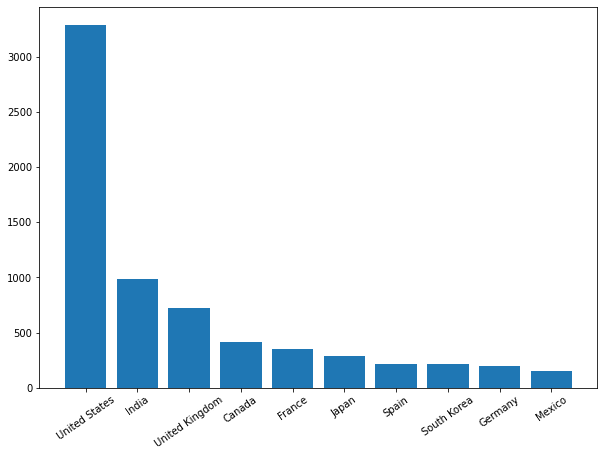

In [ ]:
tempdf = netflixdf.set_index(netflixdf.columns.drop('country',1).tolist()).country.str.split(', ', expand=True).stack().reset_index().rename(columns={0:'country'})
tempdf = tempdf.groupby(by='country').count().sort_values(['type'],ascending=False).reset_index()
print(tempdf.country.iloc[[0]].values[0], 'is the the country with most content produced, with', tempdf.type.iloc[[0]].values[0],"Movies and TV Shows")

fig , ax = plt.subplots(1,1,figsize=(10,7))
ax.bar(tempdf.country.head(10), tempdf.type.head(10))
ax.tick_params(axis='x', rotation=35)

## *Ερώτημα 4*

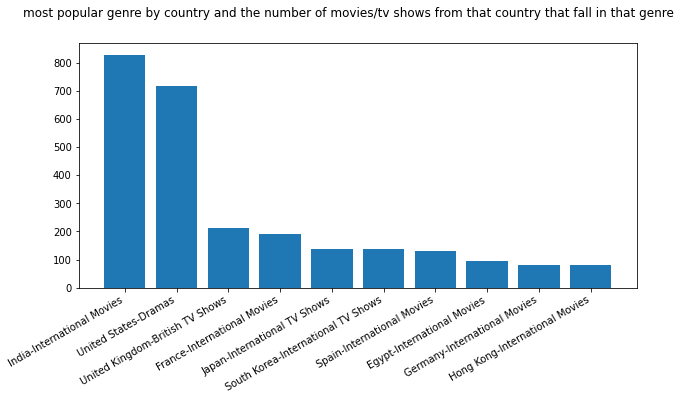

In [ ]:
tempdf = netflixdf.set_index(netflixdf.columns.drop('country',1).tolist()).country.str.split(', ', expand=True).stack().reset_index().rename(columns={0:'country'}).drop('level_11',1)
tempdf = tempdf.set_index(tempdf.columns.drop('listed_in',1).tolist()).listed_in.str.split(', ', expand=True).stack().reset_index().rename(columns={0:'genre'}).drop('level_11',1)

def q4(tempdf):
  tempdf = tempdf.groupby(['country','genre'])['show_id'].count().reset_index(name='count')
  # sort by number of movies, but save only the genre with highest number of movies in that country
  tempdf = tempdf.sort_values(by='count',ascending=False).drop_duplicates(['country'])
  # get first 10 actors of each country, if 10 exists
  yAxis = tempdf['count'].head(10).values
  xAxis = [ str(x + '-' + y) for x,y in zip(tempdf.country.head(10).values,tempdf.genre.head(10).values) ]
  #print(xAxis)
  fig, axs = plt.subplots(figsize=(10, 5))
  fig.autofmt_xdate()
  axs.bar(xAxis, yAxis)
  fig.suptitle('most popular genre by country and the number of movies/tv shows from that country that fall in that genre')

q4(tempdf)

# *Ερώτημα 5*

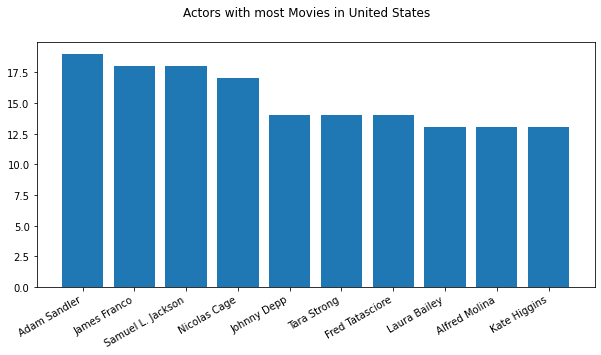

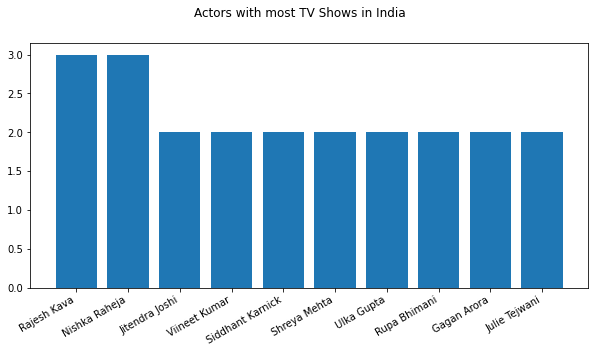

In [ ]:
tempdf = netflixdf.copy(deep=True)
tempdf.dropna(subset=['cast'] , inplace=True)
tempdf = tempdf.set_index(netflixdf.columns.drop('country',1).tolist()).country.str.split(', ', expand=True).stack().reset_index().rename(columns={0:'country'}).drop('level_11',1)
tempdf = tempdf.set_index(tempdf.columns.drop('cast',1).tolist()).cast.str.split(', ', expand=True).stack().reset_index().rename(columns={0:'actor'}).drop('level_11',1)
#tempdf = tempdf.groupby(['actor','country'])['show_id'].count().reset_index(name='count')

def q5(tempdf,country_name='United States',typee='Movie'):
  tempdf = tempdf.loc[ (tempdf['type'] == typee) & (tempdf['country'] == country_name) ].groupby(['actor','country'])['show_id'].count().reset_index(name='count')
  tempdf = tempdf.sort_values(by='count',ascending=False)

  # get first 10 actors of each country, if 10 exists
  firstNactors =  10 if tempdf.shape[0] > 10 else tempdf.shape[0]
  yAxis = tempdf['count'].head(firstNactors).values
  xAxis = tempdf.actor.head(firstNactors).values
  fig, axs = plt.subplots(figsize=(10, 5))
  fig.autofmt_xdate()
  axs.bar(xAxis, yAxis)
  fig.suptitle(str('Actors with most '+typee+'s in '+country_name))

q5(tempdf)
q5(tempdf, 'India' , 'TV Show')


# *Ερώτημα 6*

Text(0.5, 0.98, 'MOVIES                                                                                TV SHOWS')

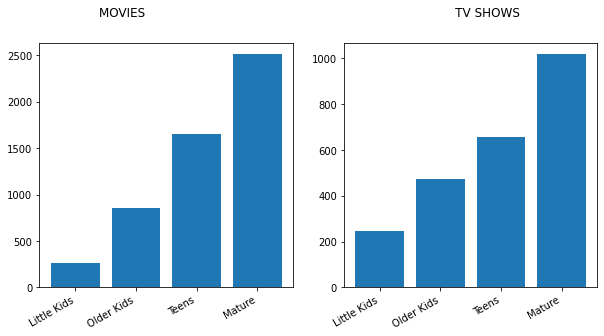

In [ ]:
Moviesdf = netflixdf.loc[ (netflixdf['type'] == 'Movie')]
TVShowdf=netflixdf.loc[ (netflixdf['type'] == 'TV Show')]


x = Moviesdf[['rating','show_id']].groupby(['rating']).count().rename(columns={'show_id':'count'}).sort_values(by=['count'], ascending=False).reset_index()
ratinglist = x['rating'].tolist()
valueslist= x['count'].tolist()

ratingDictMovies={'Little Kids':0,'Older Kids':0,"Teens":0,"Mature":0}


for  i in range(len(ratinglist)):
  if (ratinglist[i]=="G" or ratinglist[i]=="TV-Y" or ratinglist[i]=="TV-G"):
    ratingDictMovies["Little Kids"]+=valueslist[i]
  elif (ratinglist[i]=="PG" or ratinglist[i]=="TV-Y7" or ratinglist[i]=="TV-PG" or ratinglist[i]=="TV-Y7-FV"):
    ratingDictMovies["Older Kids"]+=valueslist[i]
  elif (ratinglist[i]=="PG-13" or ratinglist[i]=="TV-14"):
    ratingDictMovies["Teens"]+=valueslist[i]
  elif (ratinglist[i]=="R" or ratinglist[i]=="NC-17" or ratinglist[i]=="TV-MA"):
    ratingDictMovies["Mature"]+=valueslist[i]



x = TVShowdf[['rating','show_id']].groupby(['rating']).count().rename(columns={'show_id':'count'}).sort_values(by=['count'], ascending=False).reset_index()
ratinglist = x['rating'].tolist()
valueslist= x['count'].tolist()


ratingDictTVShow={'Little Kids':0,'Older Kids':0,"Teens":0,"Mature":0}




for  i in range(len(ratinglist)):
  if (ratinglist[i]=="G" or ratinglist[i]=="TV-Y" or ratinglist[i]=="TV-G"):
    ratingDictTVShow["Little Kids"]+=valueslist[i]
  elif (ratinglist[i]=="PG" or ratinglist[i]=="TV-Y7" or ratinglist[i]=="TV-PG" or ratinglist[i]=="TV-Y7-FV"):
    ratingDictTVShow["Older Kids"]+=valueslist[i]
  elif (ratinglist[i]=="PG-13" or ratinglist[i]=="TV-14"):
    ratingDictTVShow["Teens"]+=valueslist[i]
  elif (ratinglist[i]=="R" or ratinglist[i]=="NC-17" or ratinglist[i]=="TV-MA"):
    ratingDictTVShow["Mature"]+=valueslist[i]


ratings=list(ratingDictMovies.keys())
MovieValues=list(ratingDictMovies.values())


ShowRatings=list(ratingDictTVShow.keys())
ShowValues=list(ratingDictTVShow.values())

fig, axs = plt.subplots(1,2,figsize=(10, 5))
fig.autofmt_xdate()
axs[0].bar(ratings, MovieValues)
axs[1].bar(ShowRatings, ShowValues)
fig.suptitle('MOVIES                                                                                TV SHOWS')


## *Ερώτημα 7*
#### Μπορούμε να φτιάξουμε 2 γραφικές παραστάσεις για αυτό το πρόβλημα. Στην πρώτη θα φαίνεται το πλήθος των ταινιών για όλα τα χρόνια του κάθε μήνα από την ημερομηνία παραγωγής. Στη δεύτερη, θα απεικονίζεται ο μέσος όρος των ταινιών του κάθε χρόνου για τον εκάστοτε μήνα. Ωστόσο, στη δεύτερη περίπτωση για να μην υπάρχουν μεγάλες αποκλίσεις, για να συμπεριληφθεί μια χρονιά στον μέσο όρο, θα πρέπει η χρονιά με το μεγαλύτερο αριθμό ταινιών να μην ειναι μεγαλύτερη κατά 3 φορές από την χρονιά που συγκρίνουμε, τον μήνα αυτό.

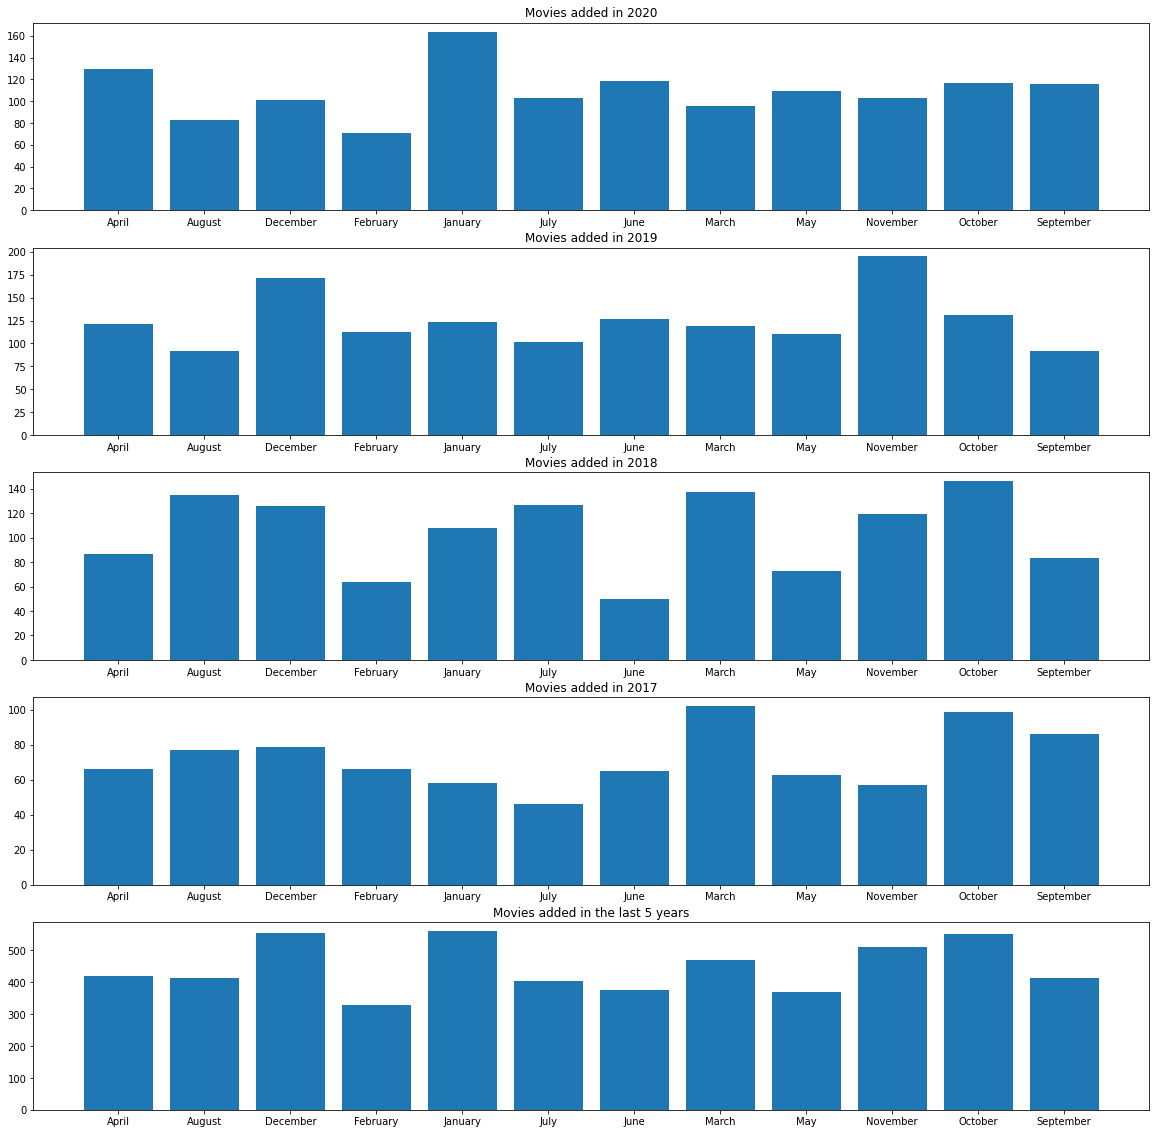

In [ ]:
def q7(tempdf, nyears=5):
  fig, axs = plt.subplots(nyears,1,figsize=(20, 20))
  for i in range(1,nyears):
    curr_year = 2021-i      
    currdf = tempdf.loc[ (tempdf['type'] == 'Movie') & (tempdf['year_added'] == curr_year)].groupby(['month_added'])['show_id'].count().reset_index(name='count')
    yAxis = currdf['count'].values
    xAxis = currdf.month_added.values
    axs[i-1].set_title(str('Movies added in '+str(curr_year))) 
    axs[i-1].bar(xAxis, yAxis)
  tempdf = tempdf.loc[ (tempdf['type'] == 'Movie') & (tempdf['year_added'] >= nyears) ].groupby(['month_added'])['show_id'].count().reset_index(name='count')
  axs[nyears-1].bar(tempdf.month_added.values, tempdf['count'].values)
  axs[nyears-1].set_title('Movies added in the last '+str(nyears)+' years')


tempdf = netflixdf.set_index(netflixdf.columns.drop('date_added',1).tolist()).date_added.str.split(' ', expand=True).reset_index().rename(columns={0:'month_added', 1:'day_added', 2:'year_added'}).astype({'year_added': 'int16'})

q7(tempdf)


# *Ερώτημα 8*

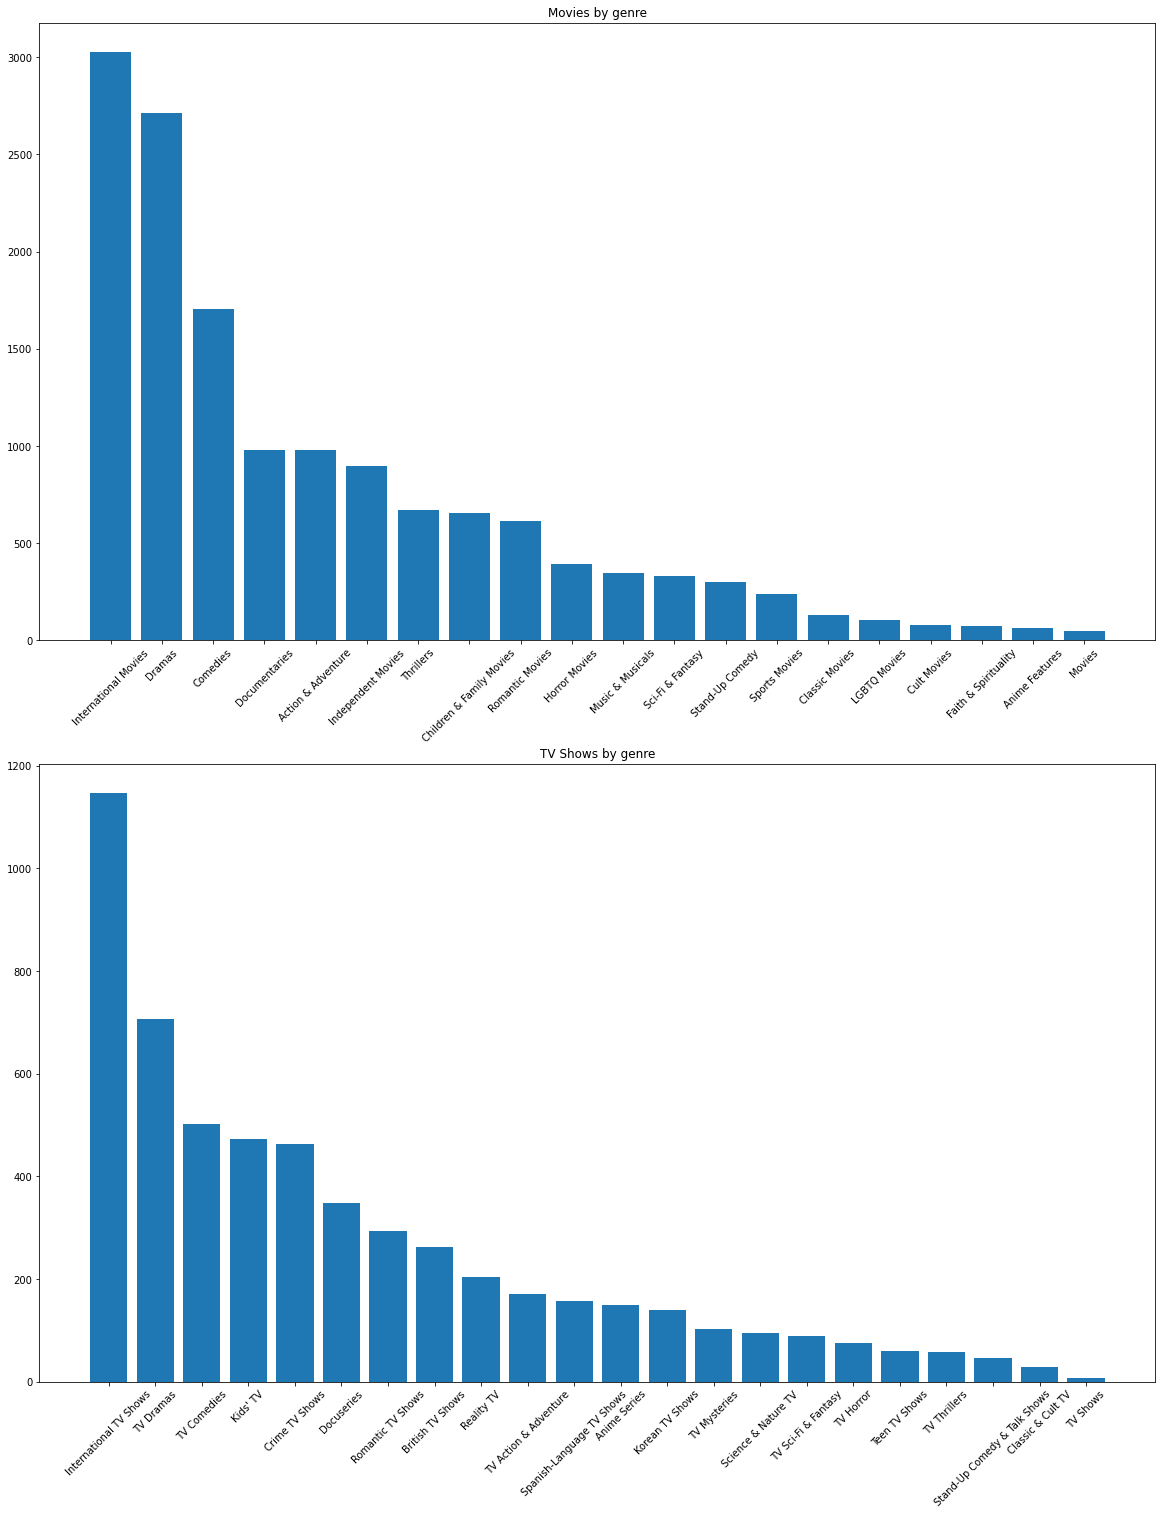

In [ ]:
tempdf = netflixdf.set_index(netflixdf.columns.drop('country',1).tolist()).country.str.split(', ', expand=True).stack().reset_index().rename(columns={0:'country'}).drop('level_11',1)
tempdf = tempdf.set_index(tempdf.columns.drop('listed_in',1).tolist()).listed_in.str.split(', ', expand=True).stack().reset_index().rename(columns={0:'genre'}).drop('level_11',1)

def q8(tempdf):
  fig, axs = plt.subplots(2,1,figsize=(20, 25))
  types = ['Movie' , 'TV Show']
  for i in range(0,2):
    currdf = tempdf.loc[ tempdf['type'] == types[i] ].groupby(['genre'])['show_id'].count().reset_index(name='count')
    currdf = currdf.sort_values(by='count',ascending=False)
    # get first 10 actors of each country, if 10 exists
    yAxis = currdf['count'].values
    xAxis = currdf['genre'].values
    #fig.autofmt_xdate()
    axs[i].bar(xAxis, yAxis)
    axs[i].set_title(types[i]+'s by genre')
    axs[i].tick_params(axis='x', rotation=45)


q8(tempdf)

# *Ερώτημα 9*

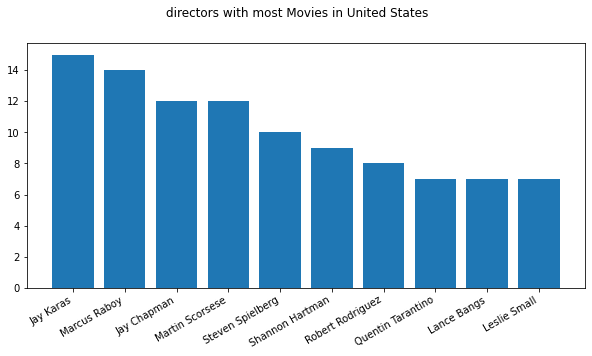

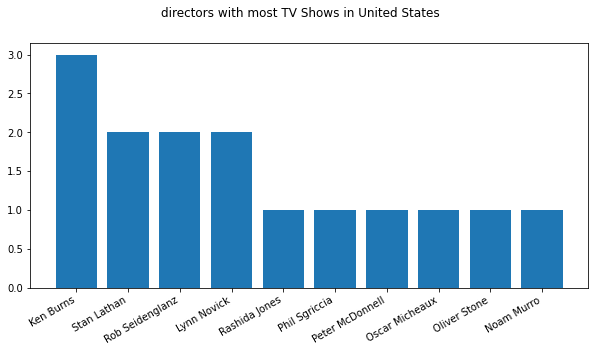

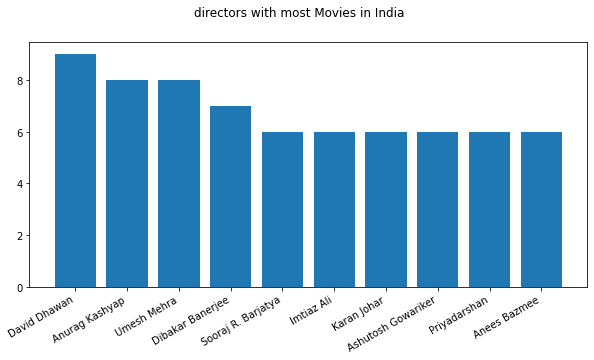

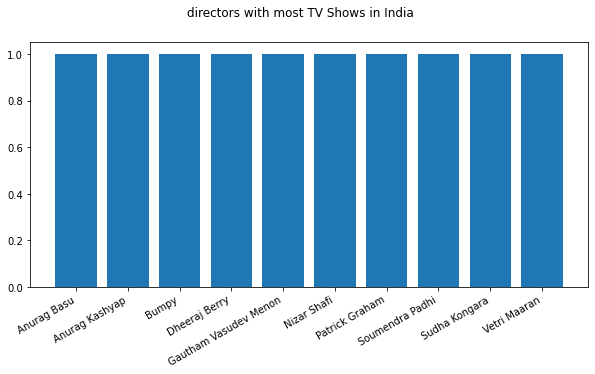

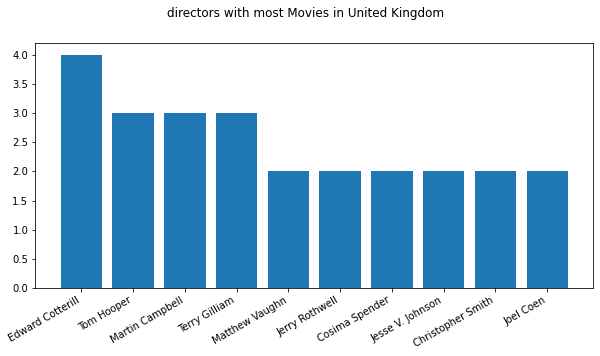

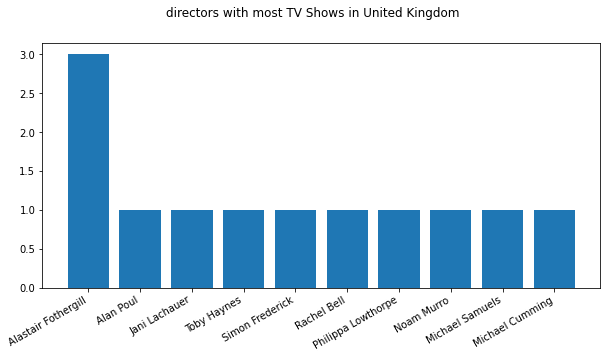

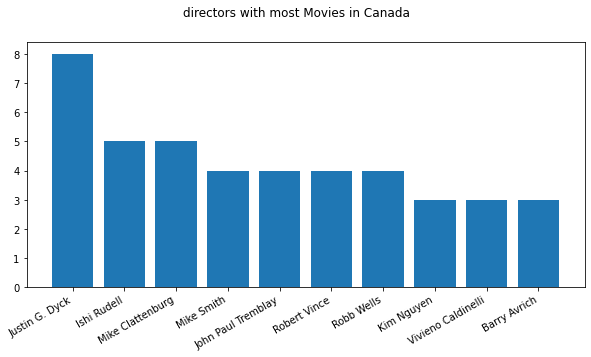

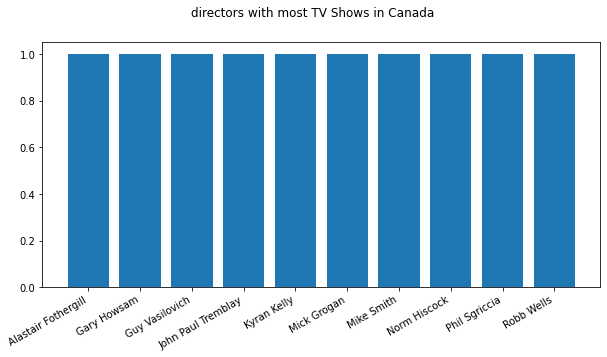

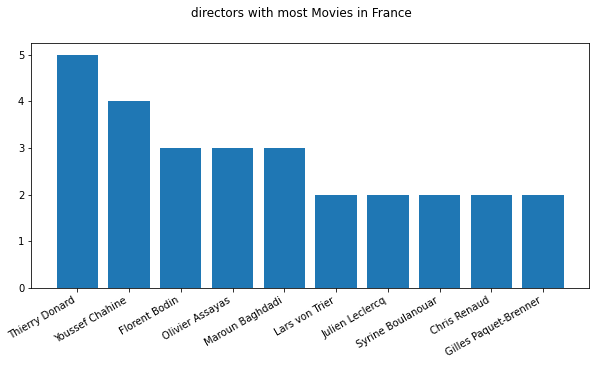

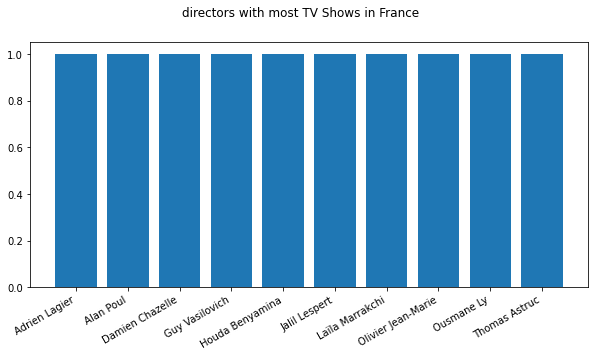

In [ ]:
tempdf = netflixdf.copy(deep=True)
tempdf.dropna(subset=['director'] , inplace=True)
tempdf = tempdf.set_index(netflixdf.columns.drop('country',1).tolist()).country.str.split(', ', expand=True).stack().reset_index().rename(columns={0:'country'}).drop('level_11',1)
tempdf = tempdf.set_index(tempdf.columns.drop('director',1).tolist()).director.str.split(', ', expand=True).stack().reset_index().rename(columns={0:'director'}).drop('level_11',1)


x = tempdf[['country','show_id']].groupby(['country']).count().rename(columns={'show_id':'count'}).sort_values(by=['count'], ascending=False).reset_index()
countrylist = x['country'].tolist()
#print(countrylist)

def q9(tempdf,country,typee):
  tempdf = tempdf.loc[ (tempdf['type'] == typee) & (tempdf['country'] == country) ].groupby(['director','country'])['show_id'].count().reset_index(name='count')
  tempdf = tempdf.sort_values(by='count',ascending=False)
  # get first 10 directors of each country, if 10 exists
  firstNdirectors =  10 if tempdf.shape[0] > 10 else tempdf.shape[0]
  yAxis = tempdf['count'].head(firstNdirectors).values
  xAxis = tempdf.director.head(firstNdirectors).values
  fig, axs = plt.subplots(figsize=(10, 5))
  fig.autofmt_xdate()
  axs.bar(xAxis, yAxis)
  fig.suptitle(str('directors with most %ss in %s'%(typee,country)))


for i in range(5): #get 5 first countries(we can get all of them if we want but that would be time consuming)
  q9(tempdf,countrylist[i],'Movie')
  q9(tempdf,countrylist[i],'TV Show')

# *Ερώτημα 10*

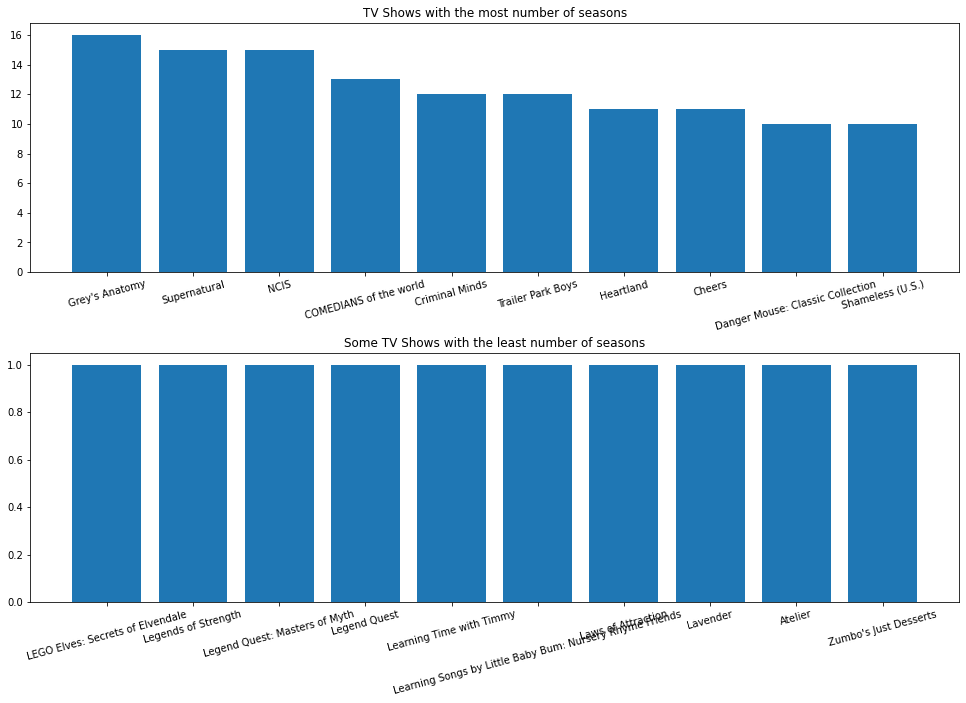

In [ ]:
tempdf = netflixdf.loc[netflixdf['type']=='TV Show']
tempdf = tempdf.set_index(netflixdf.columns.drop('duration',1).tolist()).duration.str.split(' ', expand=True).reset_index().rename(columns={0:'duration'}).astype({'duration':'int32'})
tempdf = tempdf.sort_values(by=['duration'],ascending=False)

fig, axs = plt.subplots(2,1,figsize=(15, 10))
fig.tight_layout(pad=6.0)

axs[0].bar(tempdf['title'].head(10), tempdf['duration'].head(10))
axs[0].set_title('TV Shows with the most number of seasons')
axs[0].tick_params(axis='x', rotation=15)

axs[1].bar(tempdf['title'].tail(10), tempdf['duration'].tail(10))
axs[1].set_title('Some TV Shows with the least number of seasons')
axs[1].tick_params(axis='x', rotation=15)


# Ερώτημα 11

##### Για το ερώτημα αυτό θα πάρουμε τις ταινίες με τη μεγαλύτερη βαθμολογία, αλλά θα πρέπει να έχουν τουλάχιστον 500 κριτικές ( και 100 για τις περιπτώσεις ψήφου από γυναίκες και άντρες), έτσι ώστε να είναι διαδεδομένες και ο μέσος όρος αυτών των ψήφων να έχει παρθεί από ένα μεγάλο δείγμα. 

Movies with highest weighted average votes:
                               title  weighted_average_vote
1069                       Innocent                    9.0
1750                   Pulp Fiction                    8.9
1924               Schindler's List                    8.9
1061                      Inception                    8.8
1632          Oththa Seruppu Size 7                    8.6
170   Ani... Dr. Kashinath Ghanekar                    8.6
1521         Much Ado About Nothing                    8.6
512                     City of God                    8.6
871                        Gol Maal                    8.6
1224                        Koshish                    8.6

Movies with highest mean votes:
                               title  mean_vote
823                            Game        9.5
1069                       Innocent        9.3
2127      Surga Yang Tak Dirindukan        9.1
2628                           Waar        9.0
1762                         Qismat  

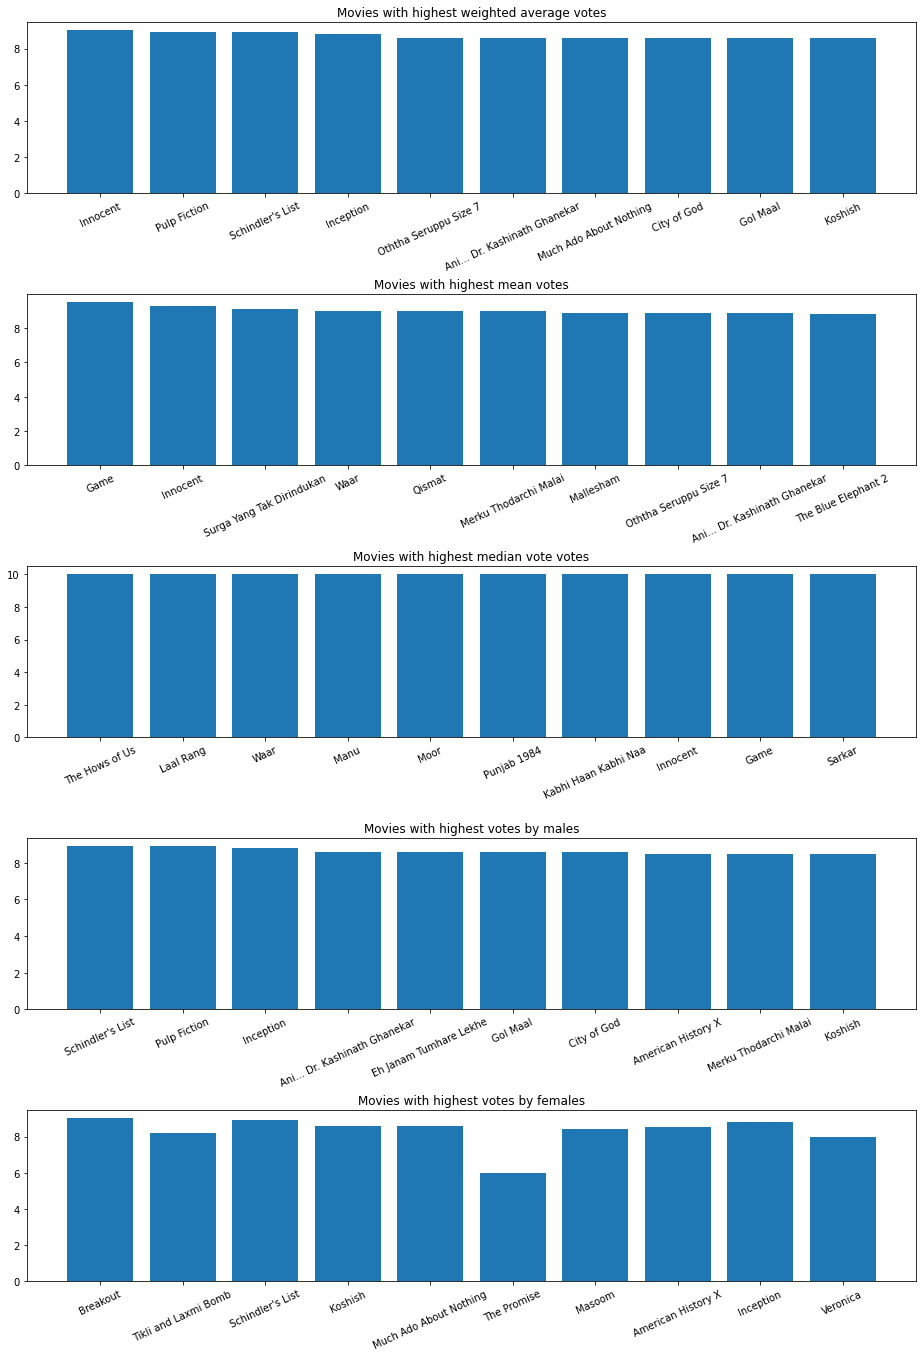

In [ ]:
# we need the original dataframe, without any deleted rows
mergeddf = pd.merge(left=netflixdf, right=moviesdf, left_on='title', right_on='title')[['show_id','title','imdb_title_id']]
mergeddf = pd.merge(left=mergeddf, right=ratingsdf, left_on='imdb_title_id', right_on='imdb_title_id')[['show_id','title','weighted_average_vote','total_votes','mean_vote','median_vote','males_allages_avg_vote','males_allages_votes','females_allages_avg_vote','females_allages_votes']]


fig , ax = plt.subplots(5,1,figsize=(15,20))
fig.tight_layout(pad=8.0)


df = mergeddf.loc[mergeddf['total_votes'] > 500].sort_values(by=['weighted_average_vote'],ascending=False)
xAxis = df['title'].head(10)
yAxis = df['weighted_average_vote'].head(10)
ax[0].bar(xAxis,yAxis)
ax[0].set_title('Movies with highest weighted average votes')
ax[0].tick_params(axis='x', rotation=25)
print('Movies with highest weighted average votes:\n',df[['title','weighted_average_vote']].head(10))


df = mergeddf.loc[mergeddf['total_votes'] > 500].sort_values(by=['mean_vote'],ascending=False)
xAxis = df['title'].head(10)
yAxis = df['mean_vote'].head(10)
ax[1].bar(xAxis,yAxis)
ax[1].set_title('Movies with highest mean votes')
ax[1].tick_params(axis='x', rotation=25)
print('\nMovies with highest mean votes:\n',df[['title','mean_vote']].head(10))


df = mergeddf.loc[mergeddf['total_votes'] > 500].sort_values(by=['median_vote'],ascending=False)
xAxis = df['title'].head(10)
yAxis = df['median_vote'].head(10)
ax[2].bar(xAxis,yAxis)
ax[2].set_title('Movies with highest median vote votes')
ax[2].tick_params(axis='x', rotation=25)
print('\nMovies with highest median votes:\n',df[['title','median_vote']].head(10))


df = mergeddf.loc[mergeddf['males_allages_votes'] > 100].sort_values(by=['males_allages_avg_vote'],ascending=False)
xAxis = df['title'].head(10)
yAxis = df['males_allages_avg_vote'].head(10)
ax[3].bar(xAxis,yAxis)
ax[3].set_title('Movies with highest votes by males')
ax[3].tick_params(axis='x', rotation=25)
print('\nMovies with highest votes by males:\n',df[['title','males_allages_avg_vote']].head(10))


df = mergeddf.loc[mergeddf['females_allages_votes'] > 100].sort_values(by=['females_allages_avg_vote'],ascending=False)
xAxis = df['title'].head(10)
yAxis = df['weighted_average_vote'].head(10)
ax[4].bar(xAxis,yAxis)
ax[4].set_title('Movies with highest votes by females')
ax[4].tick_params(axis='x', rotation=25)
print('\nMovies with highest votes by females:\n',df[['title','females_allages_avg_vote']].head(10))





#**Recommendation System** 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

# delete some rows without cast or director, because it crashes by exhausting RAM (we have really big dataset, so we need to make it a bit smaller, from 7700 rows-> 4800 rows)
netflixdf.dropna(axis=0, how='any' , inplace=True)

#### εδώ χρησιμοποιούμε την spacy για να επεξεργαστούμε τα descriptions (για ολα τα στοιχεια χρειάζεται περίπου 8 λεπτά )

In [ ]:
nlp = spacy.load("en_core_web_sm")
stopSet = {'.', ',', '-', '!', '@', '#', '$', '%', '%', '%', '^','&','*','(',')','_','+','=','\'','\"',':','—','–'}
netflixlist = []
for x in netflixdf.description:
  spaced = nlp(x)
  lemmastr = ""
  for token in spaced:
    if token.is_stop == False and not token.lemma_ in stopSet:
      lemmastr += str(token.lemma_+' ')
  netflixlist.append(lemmastr)

i = 0
for x in netflixdf.title:
  spaced = nlp(x)
  lemmastr = ""
  for token in spaced:
    if token.is_stop == False and not token.lemma_ in stopSet:
      lemmastr += str(token.lemma_+' ')
  netflixlist[i]+=lemmastr
  i+=1

print(netflixlist)

In [ ]:
stopWordsList = ['that','it','are','in','as','this','the','with','they','their','and','an','a','at','to','for','by','his','her','is','for','of','in','from','him','on']

def bow_fun(input_list):
  bow_vectorizer = CountVectorizer(max_df=1.0, min_df=1, max_features=100000,ngram_range=(1,2),stop_words=stopWordsList, binary=True)
  bow = bow_vectorizer.fit_transform(input_list)
  return bow

bow = bow_fun(netflixlist)
bowarr = bow.toarray()
#bowl = bow_vectorizer.get_feature_names()
#print(bowl)
print(bowarr,bow.shape)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] (4808, 76650)


In [ ]:
def tfidf_fun(input_list):
  tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, max_features=100000,ngram_range=(1,2),lowercase=True,stop_words=stopWordsList)
  tfidf = tfidf_vectorizer.fit_transform(input_list)
  return tfidf

tfidf = tfidf_fun(netflixlist)
tfidfarr = tfidf.toarray()
#tfidfl = tfidf_vectorizer.get_feature_names()
#print(tfidfl)
print(tfidfarr,tfidfarr.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (4808, 76650)


###*ΕΡΩΤΗΜΑ 2*

##### για λόγους χρόνου/ταχύτητας φτιάχνουμε τους πίνακες με τα similarities των πρώτων 500 ταινιών

In [ ]:

dic = {}
jacArr = np.zeros((netflixdf.shape[0],netflixdf.shape[0]))
cosArr = np.zeros((netflixdf.shape[0],netflixdf.shape[0]))

############# compute similarities 
df_size=500
for i in range(0,df_size):
  print(i)
  for j in range(0,df_size):
    key = 's' + str(i) 
    inter = bowarr[i].dot(bowarr[j])
    union = np.add(bowarr[i],bowarr[j])
    union = np.sum(union)
    jacc_score = float(inter) / float(union)
    jacArr[i][j] = jacc_score
    product = tfidfarr[i].dot(tfidfarr[j])
    magnitudes = np.linalg.norm(tfidfarr[i])*np.linalg.norm(tfidfarr[j])
    cosArr[i][j] = float(product) / float(magnitudes)
    #dic['key']= jaccard_score(bowarr[i],bowarr[j],average=None)
    #print(i,j,key,dic['key'])


#########create a dictonary with similar movies#######

similar_bow = {}
similar_tfidf = {}
#df_size = netflixdf.shape[0]
df_size = 500
ids = netflixdf['show_id']
for i in range(0,df_size):
  id_i = ids.iloc[[i]].values[0]
  similar_bow[id_i] = list()
  similar_tfidf[id_i] = list()
  temp_list_bow= []
  temp_list_tfidf= []
  for j in range(0,df_size):
    if i == j:
      continue
    id_j = ids.iloc[[j]].values[0]
    score_bow = jacArr[i][j] 
    score_tfidf = cosArr[i][j]
    temp_list_bow.append((id_j,score_bow))
    temp_list_tfidf.append((id_j,score_tfidf))
    #similar[id_i].append( (id_j, score) )     
  for k in range(0,100): 
    similar_bow[id_i].append( temp_list_bow.pop(temp_list_bow.index(max(temp_list_bow, key= lambda x:x[1]))) )
    similar_tfidf[id_i].append( temp_list_tfidf.pop(temp_list_tfidf.index(max(temp_list_tfidf, key= lambda x:x[1]))) )
  #similar[id_i].sort(key= lambda x: x[1])

print(similar_bow)  
print(similar_tfidf)

 

Output hidden; open in https://colab.research.google.com to view.

##*ΕΡΩΤΗΜΑ 3*

In [ ]:
def predict(title, N, method):
  id = netflixdf.loc[ netflixdf['title'] == title].show_id.values[0]
  prediction_list = []
  k=0
  if method == 'tf-idf':
    for sid,score in similar_tfidf[id]:
      if k > N:
        break
      prediction_list.append(netflixdf.loc[ netflixdf['show_id'] == sid].title.values[0])
      k+=1
  elif method == 'bow':
    for sid,score in similar_bow[id]:
      if k > N:
        break
      prediction_list.append(netflixdf.loc[ netflixdf['show_id'] == sid].title.values[0])
  print(prediction_list)

predict('706',10,'tf-idf')

['Atlantics', 'Bad Rap', '1898: Our Last Men in the Philippines', 'A StoryBots Christmas', 'Andhakaaram', '1000 Rupee Note', 'Ég man þig', '5 to 7', 'Ankur Arora Murder Case', '46', '93 Days']


#### Το TF-IDF βασίζεται στο BoW και συνεπώς έχουν αρκετές ομοιότητες, αφού και τα δύο έχουν ως βασική ιδέα να βρίσκουν το πλήθος των εμφανίσεων μιας λέξης. Ωστόσο, η βασική τους διαφορά έγκειται στο ότι στην TF-IDF υλοποίηση, οι λέξεις που βρίσκονται σε πολλά documents(δηλαδή έχουν μεγάλη συχνότητα στο σύνολο δεδομένων) έχουν μικρότερη βαρύτητα. Κατ'αυτόν τον τρόπο, με την τελευταία μέθοδο μπορούμε να βρούμε καλύτερα λέξεις "κλειδιά" που δεν εμφανίζονται συχνά και έτσι να βρεθεί η πιο "αρμοστή" ταινία με το input μας.

## *ΕΡΩΤΗΜΑ 4*

In [ ]:
def final_predict(description, N, method):
  inputList = netflixlist.copy()
  #insert the given description first in the list for the vectorizers
  inputList.insert(0, description)
  vectorizer = bow_fun(inputList) if method == 'bow' else tfidf_fun(inputList)
  vectorizer_arr = vectorizer.toarray()

  # now find the most similar movies with the given title
  similar_arr = np.zeros((1,netflixdf.shape[0]))
  for j in range(1,netflixdf.shape[0]+1):
    if method == 'bow':
      inter = vectorizer_arr[0].dot(vectorizer_arr[j])
      union = np.add(vectorizer_arr[0],vectorizer_arr[j])
      union = np.sum(union)
      jacc_score = float(inter) / float(union)
      similar_arr[0][j-1] = jacc_score
    else:
      product = vectorizer_arr[0].dot(vectorizer_arr[j])
      magnitudes = np.linalg.norm(vectorizer_arr[1])*np.linalg.norm(vectorizer_arr[j])
      similar_arr[0][j-1] = float(product) / float(magnitudes)

  df_data = []
  for i in range(0,netflixdf.shape[0]):
    df_items = netflixdf.iloc[[i]][['show_id','title']].values[0].tolist()
    df_items.append(similar_arr[0][i])
    df_data.append( df_items )
  
  finaldf = pd.DataFrame(df_data,columns=['show_id','title','score']).sort_values(by=['score'],ascending=False)
  print('Similar movies with the description: '+description+'  ,are:\n',finaldf['title'].head(N).values)

final_predict('terror', 10, 'tf-idf')
final_predict('Love and war', 10, 'tf-idf')

Similar movies with the description: terror  ,are:
 ['Monster House' 'All Light Will End' "Grandmother's Farm Part 2" 'Cave'
 '22-Jul' 'The Dark Crystal' 'Flying Guillotine 2' 'Residente'
 'Return To The 36th Chamber' 'Return of the Prodigal Son']
Similar movies with the description: Love and war  ,are:
 ['Love Is War' 'War Machine' 'War Horse'
 'The Last Bomb of the Second World War' 'War Chhod Na Yaar' 'Sangam'
 'Love You... Love You Not' 'Kaake Da Viyah' 'Ken Burns: The Civil War'
 'Rangoon']


#### Τα αποτελέσματα είναι αυτά που αναμέναμε. Και οι δύο τρόποι θα βρουν κάποιες κοινές λέξεις με την περιγραφή που δίνεται (ειδικότερα το tf idf θα βρεί λέξεις "κλειδιά"). Ωστόσο, βλέπουμε ότι δεν λαμβάνεται υπόψη καθόλου η ιδιαίτερη σημασιολογία της γλώσσας, αν χρησιμοποιούνται κάποια συνώνυμα δεν λαμβάνονται υπόψιν ενώ δεν είναι δυνατή η επεξεργασία και εύρεση πιο σύνθετων εκφράσεων πχ με μεταφορική λειτουργεία της γλώσσας κτλ. Είναι φανερό λοιπόν ότι αυτοί οι τρόποι επεξεργάζονται επιφανειακά και ουσιαστικά αναζητούν μόνο κοινές λέξεις.